## Задача (Sentiment Analysis)

Берем отызывы за лето (из архива с материалами или предыдущего занятия)
1. Учим conv сеть для классификации
2. Рассмотреть 2-а варианта сеточек
2.1 Инициализировать tf.keras.layers.Embedding предобученными векторами взять к примеру с https://rusvectores.org/ru/
2.2 Инициализировать слой tf.keras.layers.Embedding по умолчанию (ну то есть вам ничего не делать с весами)

Сравнить две архитектуры с предобученными весами и когда tf.keras.layers.Embedding обучается сразу со всей сеточкой, что получилось лучше

In [1]:
!wget https://gbcdn.mrgcdn.ru/uploads/asset/2800918/attachment/345557289fb373789308c13ddf55e23f.xls

--2022-06-25 10:44:49--  https://gbcdn.mrgcdn.ru/uploads/asset/2800918/attachment/345557289fb373789308c13ddf55e23f.xls
Resolving gbcdn.mrgcdn.ru (gbcdn.mrgcdn.ru)... 5.181.61.0
Connecting to gbcdn.mrgcdn.ru (gbcdn.mrgcdn.ru)|5.181.61.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3596800 (3.4M) [application/CDFV2]
Saving to: ‘345557289fb373789308c13ddf55e23f.xls’

345557289fb37378930 100%[===================>]   3.43M  1.43MB/s    in 2.4s    

2022-06-25 10:44:52 (1.43 MB/s) - ‘345557289fb373789308c13ddf55e23f.xls’ saved [3596800/3596800]



In [2]:
max_words = 20000
max_len = 2500
num_classes = 6

# Training
epochs = 50
batch_size = 512
print_batch_n = 100

In [3]:
pip install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 3.3 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [4]:
import pandas as pd

df=pd.read_excel("345557289fb373789308c13ddf55e23f.xls")

In [ ]:
df.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [ ]:
df.Rating.value_counts(normalize=True)

5    0.706036
1    0.110170
4    0.103490
3    0.044097
2    0.036207
Name: Rating, dtype: float64

In [5]:
df.drop(columns=['Date'], inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20659 entries, 0 to 20658
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Rating   20659 non-null  int64 
 1   Content  20656 non-null  object
dtypes: int64(1), object(1)
memory usage: 322.9+ KB


In [7]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, 
                                     train_size=0.8, 
                                     random_state=21, 
                                     #shuffle=True, 
                                     #stratify='new')
                                    )

In [ ]:
df_train.Rating.value_counts(normalize=True)

5    0.707206
1    0.111030
4    0.103467
3    0.042778
2    0.035518
Name: Rating, dtype: float64

### Предобработка

In [8]:
pip install stop-words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=199c5c1bc17ba840a09ca2e6a4001603566760eebb508986c988afb84a1f4b91
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [9]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.4 MB/s 
     |████████████████████████████████| 8.2 MB 9.3 MB/s 


In [10]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [11]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['Content'] = df_train['Content'].apply(preprocess_text)
df_test['Content'] = df_test['Content'].apply(preprocess_text)

In [12]:
train_corpus = " ".join(df_train["Content"])
train_corpus = train_corpus.lower()

In [13]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Отфильтруем данные

и соберём в корпус N наиболее частых токенов

In [14]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [16]:
from nltk.probability import FreqDist
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [17]:
tokens_filtered_top[:10]

['приложение',
 'удобно',
 'работать',
 'удобный',
 'отлично',
 'нравиться',
 'хороший',
 'отличный',
 'телефон',
 'супер']

In [18]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [19]:
def text_to_len(text):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    return len(result)

In [20]:
x_len = [text_to_len(text) for text in df_train["Content"]]

Выбираю max_len

(array([1.1497e+04, 2.3110e+03, 1.2670e+03, 5.2400e+02, 3.4800e+02,
        2.4600e+02, 1.1400e+02, 6.5000e+01, 5.4000e+01, 2.3000e+01,
        3.8000e+01, 8.0000e+00, 1.5000e+01, 4.0000e+00, 3.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0. ,   4.4,   8.8,  13.2,  17.6,  22. ,  26.4,  30.8,  35.2,
         39.6,  44. ,  48.4,  52.8,  57.2,  61.6,  66. ,  70.4,  74.8,
         79.2,  83.6,  88. ,  92.4,  96.8, 101.2, 105.6, 110. , 114.4,
        118.8, 123.2, 127.6, 132. ]),
 <a list of 30 Patch objects>)

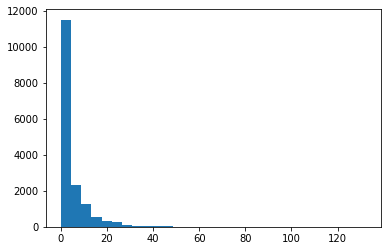

In [21]:
import matplotlib

matplotlib.pyplot.hist(x_len, bins=30)

In [22]:
import numpy as np

def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [23]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["Content"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["Content"]], dtype=np.int32)

In [24]:
x_train.shape

(16527, 2500)

In [25]:
max_len

2500

In [26]:
x_train[2]

array([0, 0, 0, ..., 8, 4, 1], dtype=int32)

# Keras model

In [27]:
pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard
#from keras.objectives import categorical_crossentropy
from keras.callbacks import EarlyStopping  

In [29]:
from keras.utils.np_utils import to_categorical

In [30]:
df_train["Rating"].value_counts()

5    11688
1     1835
4     1710
3      707
2      587
Name: Rating, dtype: int64

In [31]:
num_classes = 6

y_train = to_categorical(df_train["Rating"], num_classes)
y_test = to_categorical(df_test["Rating"], num_classes)

#y_train = keras.utils.to_categorical(df_train["Rating"], num_classes)
#y_val = keras.utils.to_categorical(df_val["Rating"], num_classes)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Epoch 1/50
30/30 [==============================] - 19s 227ms/step - loss: 1.2323 - accuracy: 0.7001 - val_loss: 0.9183 - val_accuracy: 0.7175
Epoch 2/50
30/30 [==============================] - 6s 211ms/step - loss: 0.8691 - accuracy: 0.7070 - val_loss: 0.7404 - val_accuracy: 0.7260


In [ ]:
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

9/9 [==============================] - 1s 74ms/step - loss: 0.7996 - accuracy: 0.7101


Test score: 0.799583375453949
Test accuracy: 0.7100677490234375


In [ ]:
results = model.predict(x_test, batch_size=batch_size, verbose=1)

9/9 [==============================] - 1s 67ms/step


Добавил такой же СNN слой

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Epoch 1/50
30/30 [==============================] - 13s 375ms/step - loss: 1.2853 - accuracy: 0.6583 - val_loss: 0.9449 - val_accuracy: 0.7175
Epoch 2/50
30/30 [==============================] - 11s 381ms/step - loss: 0.8421 - accuracy: 0.7275 - val_loss: 0.6931 - val_accuracy: 0.7610


In [ ]:
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

9/9 [==============================] - 1s 123ms/step - loss: 0.7589 - accuracy: 0.7423


Test score: 0.7588755488395691
Test accuracy: 0.7422555685043335


Во 2 слое увеличил в 2 раза количество

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(Conv1D(256, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Epoch 1/50
30/30 [==============================] - 18s 536ms/step - loss: 1.5261 - accuracy: 0.4152 - val_loss: 1.3392 - val_accuracy: 0.7175
Epoch 2/50
30/30 [==============================] - 15s 504ms/step - loss: 1.2814 - accuracy: 0.7062 - val_loss: 1.0902 - val_accuracy: 0.7278


In [ ]:
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

9/9 [==============================] - 2s 165ms/step - loss: 1.1614 - accuracy: 0.7103


Во 2 слое уменьшил в 2 раза количество

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(Conv1D(64, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Epoch 1/50
30/30 [==============================] - 10s 307ms/step - loss: 1.2075 - accuracy: 0.7057 - val_loss: 0.9795 - val_accuracy: 0.7175
Epoch 2/50
30/30 [==============================] - 9s 308ms/step - loss: 0.9478 - accuracy: 0.7068 - val_loss: 0.8087 - val_accuracy: 0.7223


In [ ]:
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

9/9 [==============================] - 1s 98ms/step - loss: 0.8853 - accuracy: 0.7076


In [ ]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(Conv1D(128, 6))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Epoch 1/50
30/30 [==============================] - 15s 425ms/step - loss: 1.6200 - accuracy: 0.4386 - val_loss: 1.3172 - val_accuracy: 0.7157
Epoch 2/50
30/30 [==============================] - 13s 425ms/step - loss: 1.0360 - accuracy: 0.7149 - val_loss: 0.7923 - val_accuracy: 0.7459


In [ ]:
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

9/9 [==============================] - 1s 124ms/step - loss: 0.8679 - accuracy: 0.7219


In [ ]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(Conv1D(128, 2))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Epoch 1/50
30/30 [==============================] - 12s 361ms/step - loss: 1.2943 - accuracy: 0.6828 - val_loss: 1.0224 - val_accuracy: 0.7175
Epoch 2/50
30/30 [==============================] - 11s 354ms/step - loss: 0.9873 - accuracy: 0.7061 - val_loss: 0.8112 - val_accuracy: 0.7175


In [ ]:
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

9/9 [==============================] - 1s 123ms/step - loss: 0.8837 - accuracy: 0.7014


In [ ]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Epoch 1/50
30/30 [==============================] - 18s 548ms/step - loss: 1.1760 - accuracy: 0.6997 - val_loss: 0.9555 - val_accuracy: 0.7175
Epoch 2/50
30/30 [==============================] - 15s 516ms/step - loss: 0.9528 - accuracy: 0.7061 - val_loss: 0.8105 - val_accuracy: 0.7175


In [ ]:
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

9/9 [==============================] - 2s 175ms/step - loss: 0.8757 - accuracy: 0.7014


# Предобученные эмбеддинги

https://keras.io/examples/nlp/pretrained_word_embeddings/

http://vectors.nlpl.eu/repository/20/220.zip

https://sohabr.net/habr/post/417767/

In [32]:
!wget http://vectors.nlpl.eu/repository/20/220.zip

--2022-06-25 10:48:06--  http://vectors.nlpl.eu/repository/20/220.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 638171816 (609M) [application/zip]
Saving to: ‘220.zip’

220.zip             100%[===================>] 608.61M  23.1MB/s    in 28s     

2022-06-25 10:48:34 (22.0 MB/s) - ‘220.zip’ saved [638171816/638171816]



In [33]:
!unzip 220.zip

Archive:  220.zip
  inflating: meta.json               
  inflating: model.bin               
  inflating: model.txt               
  inflating: README                  


In [34]:
!ls

220.zip				      meta.json  model.txt  sample_data
345557289fb373789308c13ddf55e23f.xls  model.bin  README


In [35]:
!rm 220.zip

In [36]:
embeddings_index = {}
f = open('model.txt')
for line in f:
    values = line.split()
    word = values[0].split(sep='_')
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word[0]] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 205708 word vectors.


In [37]:
len(embeddings_index['год'])

300

In [39]:
EMBEDDING_DIM = 300

In [40]:
embedding_matrix = np.zeros((len(tokens_filtered_top) + 1, EMBEDDING_DIM))
for i, word in enumerate(tokens_filtered_top):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


In [41]:
embedding_matrix[0][:10]

array([ 0.67161459,  1.38163257,  0.08561832,  0.95518339, -0.08028293,
        0.31145373,  0.5631389 ,  0.18648377,  1.85269451,  1.29829526])

In [43]:
max_words=11297

In [44]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=300, input_length=max_len, 
                    weights=[embedding_matrix], trainable=False))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

Epoch 1/50
30/30 [==============================] - 28s 463ms/step - loss: 0.9599 - accuracy: 0.6980 - val_loss: 0.7878 - val_accuracy: 0.7417
Epoch 2/50
30/30 [==============================] - 13s 431ms/step - loss: 0.7849 - accuracy: 0.7450 - val_loss: 0.7359 - val_accuracy: 0.7598


In [45]:
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

9/9 [==============================] - 2s 170ms/step - loss: 0.8121 - accuracy: 0.7306


# ВЫВОДЫ

   Предобученная модель дала метрику ниже чем с тренируемыми весами. Возможно больше метрику покажет хваленая GeoWAC, но она весит в 2-3 раза больше.
   Из тренируемых самую большую метрику при output_dim==128 показала модель с двумя одинаковыми конволюционными слоями.